In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import datetime
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리 가져온다.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 지정하기
plt.rcParams['font.family'] = 'gulim'

In [3]:
weather = pd.read_csv('기상대기정보.csv', encoding='UTF-8')
weather.head(2)

,지점명,일시,지점,기온(°C),강수여부,풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),...,Ozon,NO2,CO,SO2,증기압(hPa),이슬점온도(°C),시정(10m),지면온도(°C),월,전날기온
0,철원,2018-08-02 01:00:00,95,28.2,0,1.0,50.0,79.0,987.3,1004.6,...,0.023,0.003,0.3,0.001,30.2,24.2,1522.0,27.7,8,25.0
1,철원,2018-08-02 02:00:00,95,27.3,0,0.7,90.0,85.0,987.5,1004.9,...,0.024,0.003,0.3,0.001,30.7,24.5,1346.0,26.8,8,24.2


In [4]:
weather['지점명'].unique()

array(['철원', '동두천', '파주', '백령도', '동해', '서울', '인천', '원주', '울릉도', '수원',
       '충주', '서산', '대전', '상주', '포항', '대구', '울산', '창원', '광주', '부산', '목포',
       '여수', '순천', '홍성', '제주', '서귀포', '진주', '강화', '양평', '정선군', '제천', '천안',
       '임실', '고창군', '영광군', '김해시', '순창군', '해남', '광양시', '영주', '거창', '밀양',
       '거제', '속초', '영월', '울진', '완도', '인제', '홍천', '태백', '보성군', '장흥', '함양군',
       '합천', '이천', '봉화'], dtype=object)

# 서울 관측소 기온 시계열 분석

In [6]:
w_seoul = weather[weather['지점명']=='서울'][['일시','기온(°C)']]
w_seoul.head(2)

,일시,기온(°C)
20325,2018-01-01 00:00:00,-3.2
20326,2018-01-01 03:00:00,-4.0


In [94]:
w_seoul['일시'] = pd.to_datetime(w_seoul['일시'])

In [95]:
w_seoul['일시'] = w_seoul['일시'].dt.date

In [96]:
w_seoul = w_seoul.groupby('일시').mean().reset_index()

In [97]:
w_seoul['일시'] = pd.to_datetime(w_seoul['일시'])
w_seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일시      1763 non-null   datetime64[ns]
 1   기온(°C)  1763 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.7 KB


In [98]:
# 학습용, 검증용 데이터 분리
w_tr = w_seoul[w_seoul['일시']<'2022-07-01']
w_te = w_seoul[w_seoul['일시']>='2022-07-01']

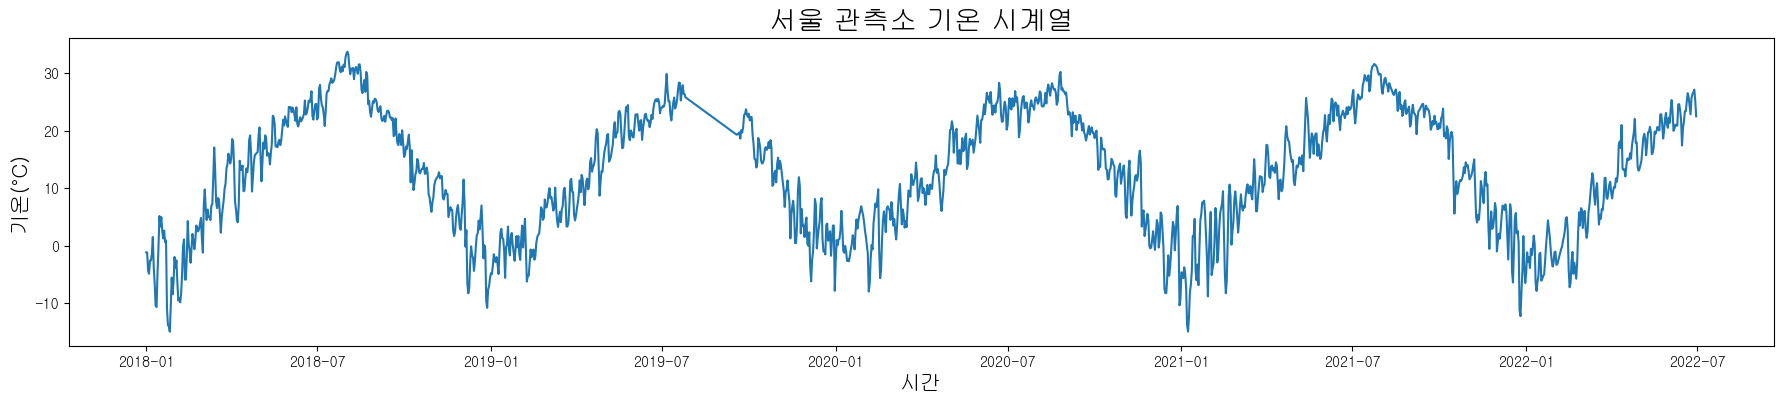

In [101]:
# 시계열 그래프
plt.figure(figsize=(22,4))
plt.plot(w_tr['일시'], w_tr['기온(°C)'])
plt.title('서울 관측소 기온 시계열', fontsize=20)
plt.xlabel('시간', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.show()

### 시계열 그래프 해석
- 우리가 평소 아는 것과 같이 일년을 주기로 계절성을 보임

## 시계열 분해

In [102]:
ts_tr = w_tr.drop('일시', axis=1)
ts_te = w_te.drop('일시', axis=1)
ts

,기온(°C)
0,-1.138889
1,-1.166667
2,-4.350000
3,-4.883333
4,-2.566667
...,...
1758,-2.641667
1759,-2.916667
1760,-3.654545
1761,-1.383333


<Figure size 640x480 with 0 Axes>

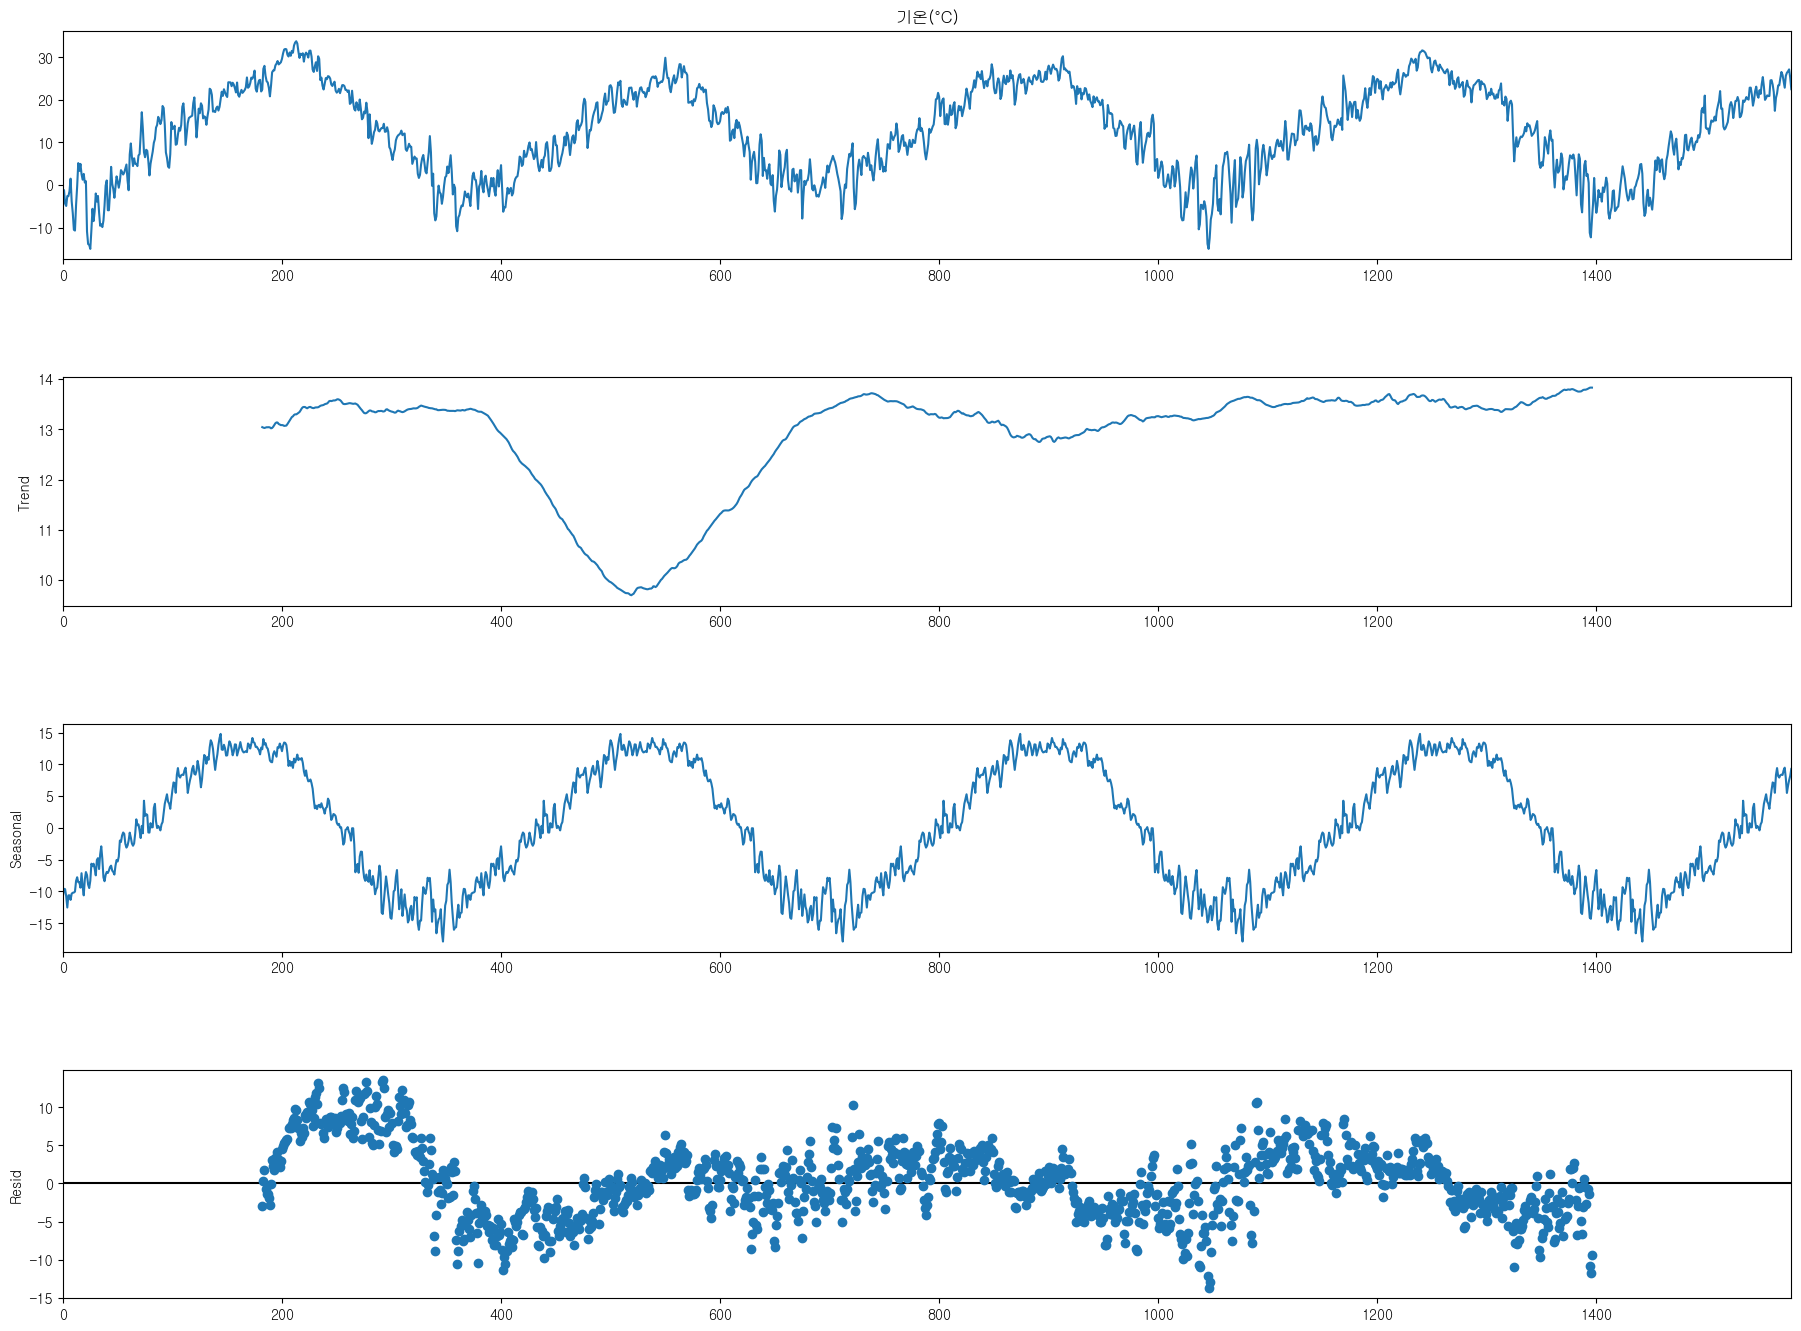

In [103]:
result = seasonal_decompose(ts_tr['기온(°C)'], model='additive', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

## 시계열 분해 그래프 해석
- 계절성에서 패턴이 보이고, 불규칙 요소에서도 패턴이 보임
- 정상성을 만족하지 못 할 것을 예상할 수 있음

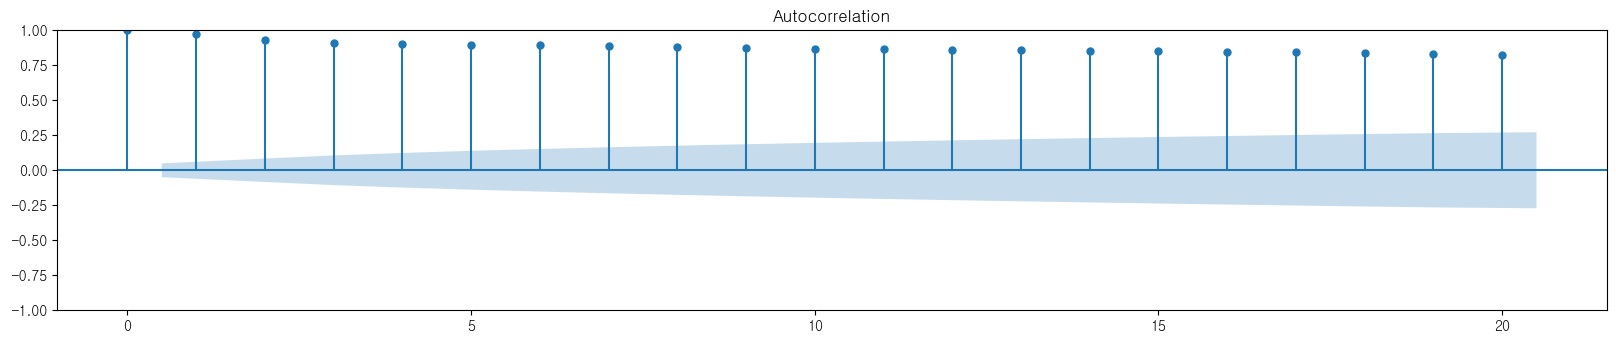

In [104]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_tr, lags=20, ax=ax1)

In [105]:
adfuller(ts_tr) # p-value: 0.279

(-2.017210602346957,
 0.27907820537711614,
 19,
 1559,
 {'1%': -3.4345514752023365,
  '5%': -2.863395697445539,
  '10%': -2.567757942139848},
 6983.313498828342)

### ACF 값 그래프 해석
- ACF 값이 아주 천천히 감소: 정상성 만족 못할 것을 예상
- ADF 검정 결과: H0 기각 못함 = 정상성 만족 못함

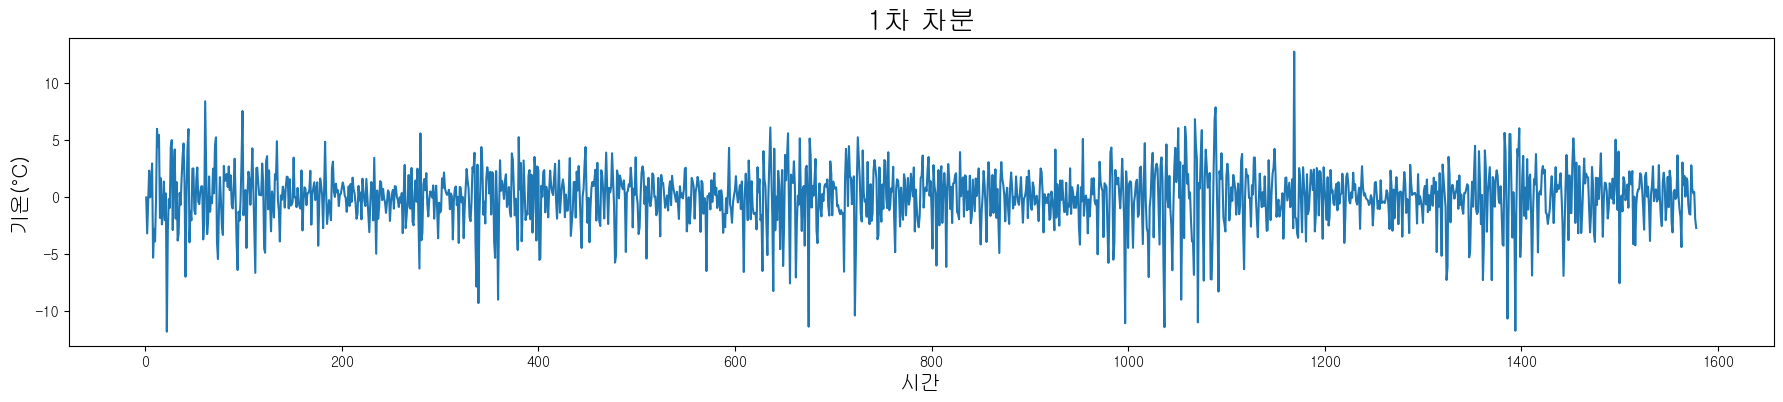

In [106]:
# 1차 차분
ts_tr_diff = ts_tr - ts_tr.shift()
plt.figure(figsize=(22,4))
plt.plot(ts_tr_diff)
plt.title('1차 차분', fontsize=20)
plt.xlabel('시간', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.show()

In [107]:
adfuller(ts_tr_diff.loc[1:,:]) # p-value: 3.669e-11

(-7.526660499911238,
 3.6694988229538434e-11,
 24,
 1553,
 {'1%': -3.4345677345088688,
  '5%': -2.8634028737525887,
  '10%': -2.5677617635268795},
 6975.908916236074)

### 1차 차분 그래프 해석
- 일정한 패턴이 사라짐
- 정상성 만족할 것을 예상
- ADF 검정 결과: H0 기각 = 정상성 만족
- d = 1

C:\Users\songh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


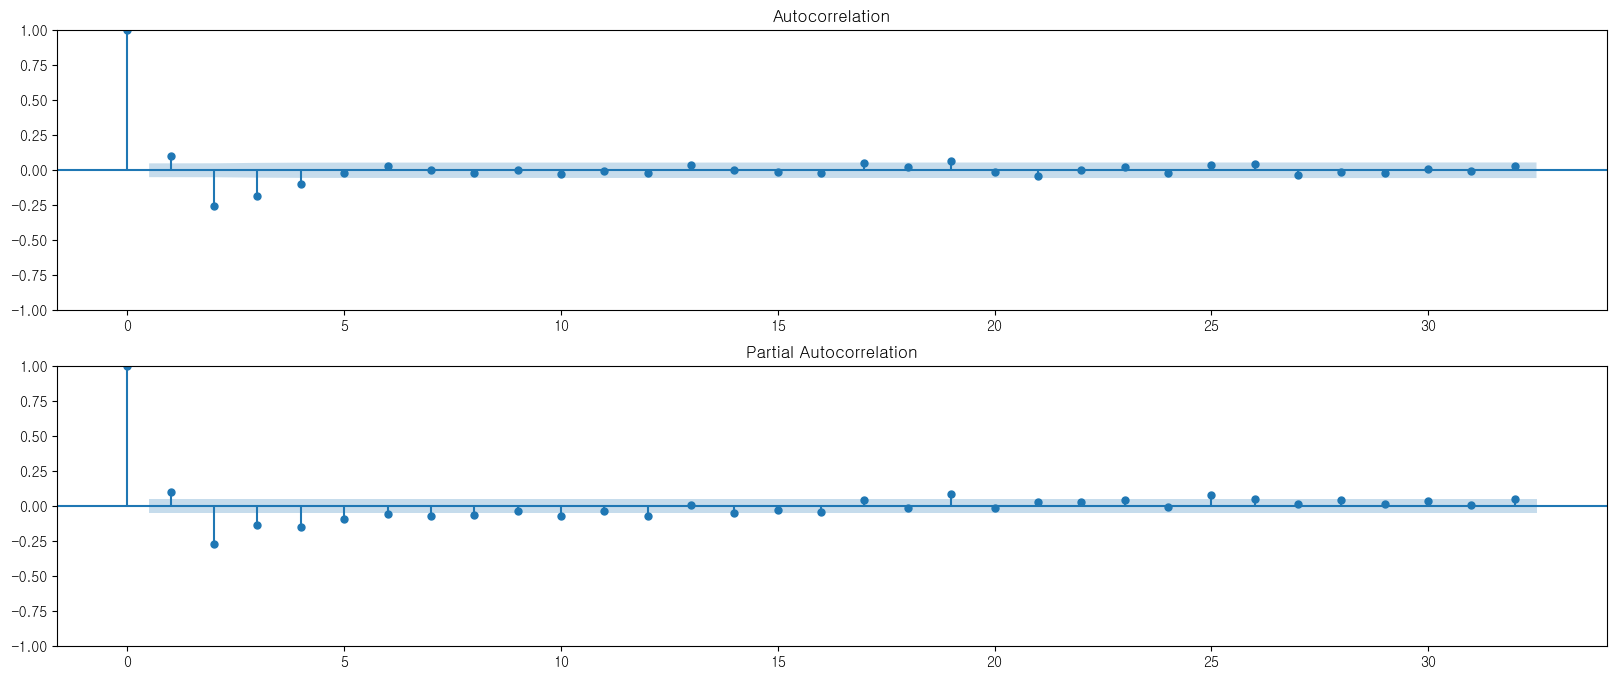

In [108]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_tr_diff[1:], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_tr_diff[1:], ax=ax2)

### 차분 데이터로 그린 ACF와 PACF 그래프 해석
- ACF 그래프는 4번째 lag 이후에 0에 수렴
- PACF 그래프는 5번째 lag 이후에 0에 수렴
- p = 5, q = 4

In [120]:
# ARIMA(5,1,4) 모형
model = sm.tsa.arima.ARIMA(ts_tr, order=(5,1,4))
model_fit = model.fit()

s_idx = datetime(2018,1,1)
e_idx = datetime(2022,6,30)
forecast = model_fit.predict(start=s_idx, end=e_idx, typ='levels')

C:\Users\songh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TypeError: 'module' object is not callable

In [65]:
w_seoul

,일시,기온(°C)
0,2018-01-01,-1.138889
1,2018-01-02,-1.166667
2,2018-01-03,-4.350000
3,2018-01-04,-4.883333
4,2018-01-05,-2.566667
...,...,...
1758,2022-12-27,-2.641667
1759,2022-12-28,-2.916667
1760,2022-12-29,-3.654545
1761,2022-12-30,-1.383333
